# Trabajo práctico - Aprendizaje Automático I

Vamos a trabajar con el dataset `weatherAUS.csv` que contiene información sobre el clima de Australia en los últimos diez años. El objetivo es usar la información del dataset para predecir los atributos `RainTomorrow` y `RainfallTomorrow` con nuevos datos. Para esto vamos a utilizar modelos de regresión lineal, regresión logística y redes neuronales.

# Análisis exploratorio y limpieza de datos

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter('ignore')

In [33]:
df_original = pd.read_csv('datasets/weatherAUS.csv', index_col=0)

# Columnas

* **Sunshine:** Numero de horas de sol en el dia
* **Rainfall:** Cantidad de lluvia en el dia en mm
* **Evaporation:** La denominada evaporación del recipiente Clase A (mm) en el período de 24 horas a las 9 a.m.
* **WindGustDir:** La dirección de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche
* **WindGustSpeed:** La velocidad (km/h) de la ráfaga de viento más fuerte en las 24 horas previas a la medianoche
* **WindDir9am:** Dirección del viento a las 9 a.m.
* **WindDir3pm:** direccion del viento alas 3pm
* **WindSpeed9am:** Velocidad del viento (km/h) promediada durante 10 minutos antes de las 9 a.m.
* **WindSpeed3pm:** Velocidad del viento (km/h) promediada durante 10 minutos antes de las 3 p.m.
* **Humidity9am:** Humedad (porcentaje) a las 15:00 horas
* **Humidity3pm:**
* **Pressure9am:** La presión atmosférica (hpa) se redujo al nivel medio del mar a las 9 a. m.
* **Pressure3pm:**
* **Cloud9am:** Fracción del cielo oscurecida por las nubes a las 9:00 horas. Esto se mide en "oktas", que son una unidad de octavos. Registra cuántas octavas partes del cielo están oscurecidas por las nubes. Una medida 0 indica cielo completamente despejado mientras que un 8 indica que está completamente nublado.
* **Cloud3pm:**
* **Temp9am:** Temperatura (grados C) a las 9 a.m.
* **Temp3pm:**
* **RainToday:** Booleano: 1 si la precipitación (mm) en las 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0
* **RainTomorrow:** La cantidad de lluvia del día siguiente en mm. Se utiliza para crear la variable de respuesta RainTomorrow. Una especie de medida del "riesgo".
* **RainfallTomorrow:** ESTA COLUMNA LA AGREGARON LOS PROFES!!!!!

https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

Para entrenar los modelos solamente vamos a usar cinco ciudades del dataset

In [34]:
ciudades = ['Sydney',
            'SydneyAirport',
            'Canberra',
            'Melbourne',
            'MelbourneAirport']

df = df_original[df_original['Location']\
                 .isin(ciudades)]\
                 .copy()\
                 .reset_index(drop=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15986 entries, 0 to 15985
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              15986 non-null  object 
 1   Location          15986 non-null  object 
 2   MinTemp           15495 non-null  float64
 3   MaxTemp           15500 non-null  float64
 4   Rainfall          15199 non-null  float64
 5   Evaporation       14280 non-null  float64
 6   Sunshine          14038 non-null  float64
 7   WindGustDir       14529 non-null  object 
 8   WindGustSpeed     14531 non-null  float64
 9   WindDir9am        15291 non-null  object 
 10  WindDir3pm        15696 non-null  object 
 11  WindSpeed9am      15725 non-null  float64
 12  WindSpeed3pm      15737 non-null  float64
 13  Humidity9am       15416 non-null  float64
 14  Humidity3pm       15461 non-null  float64
 15  Pressure9am       15251 non-null  float64
 16  Pressure3pm       15260 non-null  float6

In [36]:
df.sort_values(['Location', 'Date'], inplace=True)

Imputamos los datos que no son medidas estadicas antes de separar el dataset

## MinTemp y MaxTemp

Para estas variables decidimos usar una interpolación, ya que la temperatura de los días faltantes probablemente se encuentre en algún punto entre la temperatura del día anterior y la del día posterior.

In [37]:
df['MinTemp'].interpolate(method='linear', inplace=True)
df['MaxTemp'].interpolate(method='linear', inplace=True)

## WindDir 

Para la direcciones viento elegimos llenarla con el valor siguiete valido ya que es daset esta ordenado por fecha. 

In [38]:
df['WindDir9am'].fillna(method='ffill', inplace=True)
df['WindDir3pm'].fillna(method='ffill', inplace=True)

## WindGustDir 🟡

Como esta variable tiene años faltantes y teniendo las variables `WindDir9am` y `WindDir3pm` decidimos eliminarla del dataframe.

## RainToday y RainTomorrow

Los valores Nan de estas dos variables son muy pocos por eso decidimos eliminarlos.

In [39]:
df.RainToday.isna().sum()

787

In [40]:
df.RainTomorrow.isna().sum()

787

In [41]:
df.dropna(subset=["RainTomorrow"],inplace=True)


In [42]:
df.dropna(subset=["RainToday"],inplace=True)

Separamos el dataset para en entrenamiento y prueba

In [44]:
x_reg = df.drop(columns=['RainTomorrow', 'RainfallTomorrow'])
y_reg = df['RainfallTomorrow']

x_clas = x_reg
y_clas = df['RainTomorrow']

x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=0.2, random_state=1)
x_train_clas, x_test_clas, y_train_clas, y_test_clas = train_test_split(x_clas, y_clas, test_size=0.2, random_state=1)

## ¿Está balanceado el dataset?

### Dataset regresión

El dataset no está balanceado porque la variable independietne que queremos predecir tiene muchos valores iguales a $0$.

<Axes: >

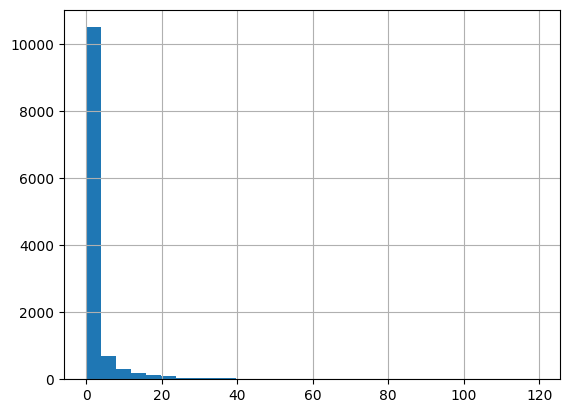

In [45]:
y_train_reg.hist(bins=30)

In [49]:
y_train_reg.shape

(12788,)

In [48]:
y_train_reg.value_counts()

RainfallTomorrow
0.0     7784
0.2      673
0.4      328
0.6      249
1.0      154
        ... 
35.0       1
76.4       1
67.8       1
26.0       1
94.4       1
Name: count, Length: 266, dtype: int64

In [53]:
f'{7784/12788:.2f}'

'0.61'

En el histograma vemos gráficamente que el dataset está desbalanceado, ya que la moda es $0$ y con los valores vemos que aproximadamente el $61\%$ de los valores de la variable a predecir son $0$.

### Dataset clasificación

<Axes: >

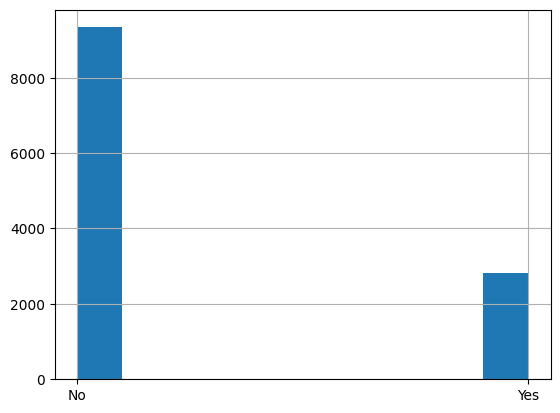

In [55]:
y_train_clas.hist()

In [58]:
y_train_clas.shape

(12788,)

In [57]:
y_train_clas.value_counts()

RainTomorrow
No     9337
Yes    2825
Name: count, dtype: int64

In [59]:
f'{9337/12788:.2f}'

'0.73'

Para el caso del dataset que usaremos para la clasificación también vemos que hay un importante desbalanceo, ya que el $73\%$ de sus valores pertenecen a una de las clases.

## Scatter plot

## Imputación de datos

In [45]:
df_reg  = pd.concat([x_train_reg, y_train_reg], axis=1)
df_clas = pd.concat([x_train_clas, y_train_clas], axis=1)



### Rainfall

Para completar la variable `Rainfall` vamos a usar la moda de la distribución que es `0.0`, eso lo podemos comprobar con el siguiente histograma y loop.

Text(0.5, 1.0, 'Dataset Clasificación')

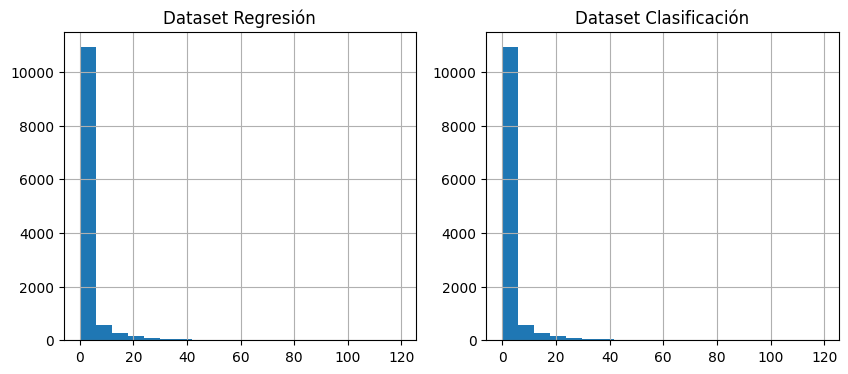

In [24]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
df_reg['Rainfall'].hist(bins=20)
plt.title('Dataset Regresión')
plt.subplot(122)
df_clas['Rainfall'].hist(bins=20)
plt.title('Dataset Clasificación')

In [25]:
for ciudad in ciudades:
    rain = \
        df_reg[df_reg['Location'] == ciudad]['Rainfall'].mode()[0]
    print(f'{ciudad + ":":17} {rain}')

Sydney:           0.0
SydneyAirport:    0.0
Canberra:         0.0
Melbourne:        0.0
MelbourneAirport: 0.0


In [26]:
for ciudad in ciudades:
    rain = \
        df_clas[df_clas['Location'] == ciudad]['Rainfall'].mode()[0]
    print(f'{ciudad + ":":17} {rain}')

Sydney:           0.0
SydneyAirport:    0.0
Canberra:         0.0
Melbourne:        0.0
MelbourneAirport: 0.0


In [27]:
df_reg['Rainfall'].fillna(0.0, inplace=True)
df_clas['Rainfall'].fillna(0.0, inplace=True)

### Evaporation

En esta variable vemos que la distribución es bastante simétrica, además la media y la mediana tiene valores muy cercanos, en esta caso no hay sesgo, por lo tanto decidimos completar los valores faltante con la media.

Text(0.5, 1.0, 'Dataset Clasificación')

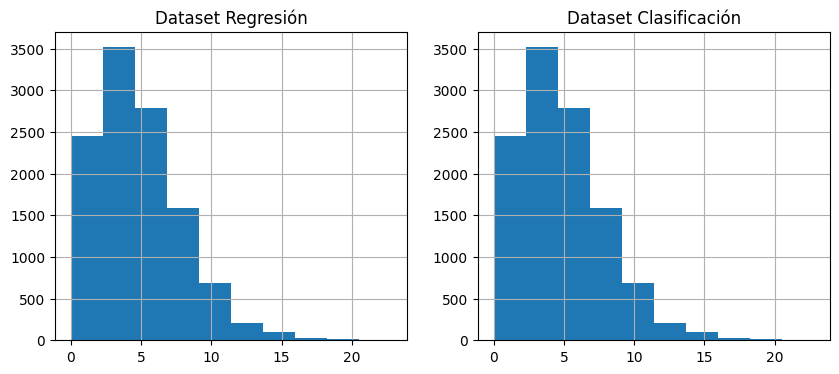

In [28]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
df_reg['Evaporation'].hist()
plt.title('Dataset Regresión')
plt.subplot(122)
df_clas['Evaporation'].hist()
plt.title('Dataset Clasificación')

In [34]:
df_reg['Evaporation'].mean(), df_reg['Evaporation'].median()

(4.8816483998246385, 4.2)

In [35]:
df_clas['Evaporation'].mean(), df_clas['Evaporation'].median()

(4.8816483998246385, 4.2)

In [36]:
df_reg['Evaporation'].fillna(df_reg['Evaporation'].mean(), inplace=True)
df_clas['Evaporation'].fillna(df_clas['Evaporation'].mean(), inplace=True)

### Sunshine

En este histograma vemos que la distribución es bimodal, por lo que para imputar los valores faltantes vamos usar la mediana, ya que la media está sesgada por la gran cantidad de `0.0`

Text(0.5, 1.0, 'Dataset Clasificación')

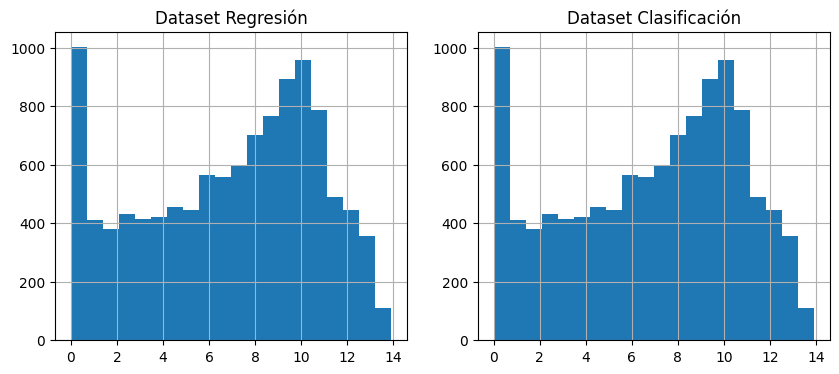

In [39]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
df_reg['Sunshine'].hist(bins=20)
plt.title('Dataset Regresión')
plt.subplot(122)
df_clas['Sunshine'].hist(bins=20)
plt.title('Dataset Clasificación')

In [40]:
df_reg['Sunshine'].fillna(df_reg['Sunshine'].median(), inplace=True)
df_clas['Sunshine'].fillna(df_clas['Sunshine'].median(), inplace=True)

### WindSpeed

En este caso observando los histogramas vemos que podemos completar los valores faltantes con la media.

Text(0.5, 1.0, 'Clasificación - WindSpeed3pm')

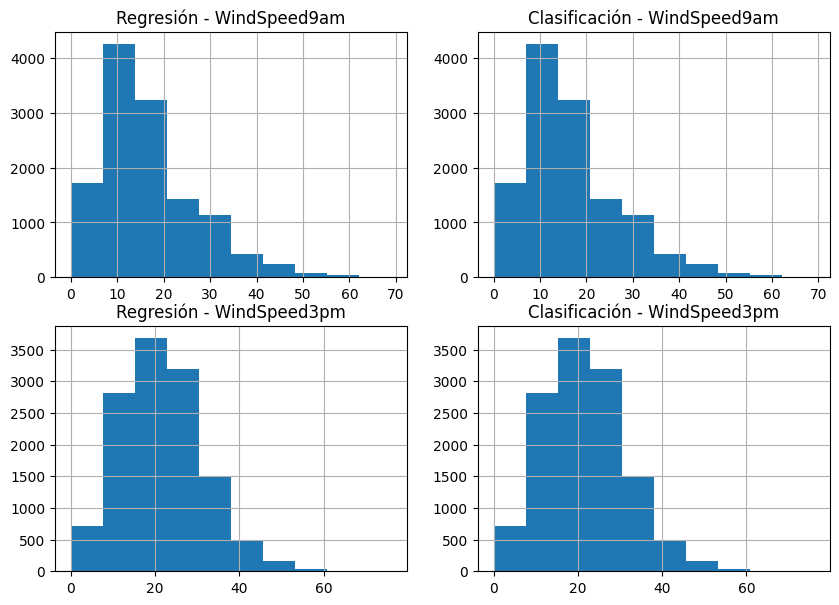

In [44]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['WindSpeed9am'].hist()
plt.title('Regresión - WindSpeed9am')
plt.subplot(222)
df_clas['WindSpeed9am'].hist()
plt.title('Clasificación - WindSpeed9am')
plt.subplot(223)
df_reg['WindSpeed3pm'].hist()
plt.title('Regresión - WindSpeed3pm')
plt.subplot(224)
df_clas['WindSpeed3pm'].hist()
plt.title('Clasificación - WindSpeed3pm')

In [46]:
df_reg['WindSpeed9am'].fillna(df_reg['WindSpeed9am'].mean(),inplace=True)
df_clas['WindSpeed9am'].fillna(df_clas['WindSpeed9am'].mean(),inplace=True)

df_reg['WindSpeed3pm'].fillna(df_reg['WindSpeed3pm'].mean(),inplace=True)
df_clas['WindSpeed3pm'].fillna(df_clas['WindSpeed3pm'].mean(),inplace=True)

### WindSGustSpeed

Vemos que la media y la media son similares esto nos dice que la distribucion es simetrica por lo cual lo llenamos con la mediana

In [47]:
df.WindGustSpeed.describe()

count    15036.000000
mean        44.167531
std         14.222581
min         11.000000
25%         35.000000
50%         43.000000
75%         52.000000
max        122.000000
Name: WindGustSpeed, dtype: float64

In [48]:
df_reg['WindSpeed3pm'].fillna(df_reg['WindSpeed3pm'], inplace=True)
df_clas['WindSpeed3pm'].fillna(df_clas['WindSpeed3pm'], inplace=True)

### Humidity

falta terminar

<AxesSubplot: >

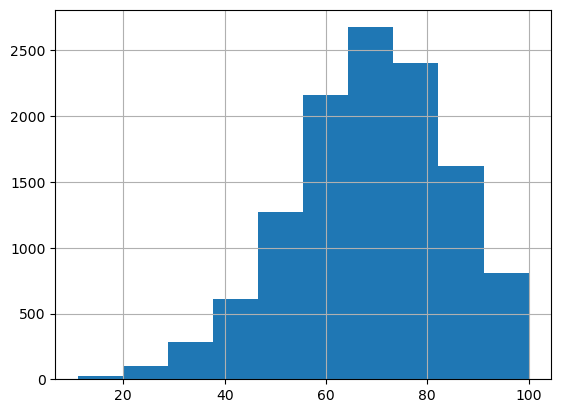

In [49]:
df_reg['Humidity9am'].hist()

<AxesSubplot: >

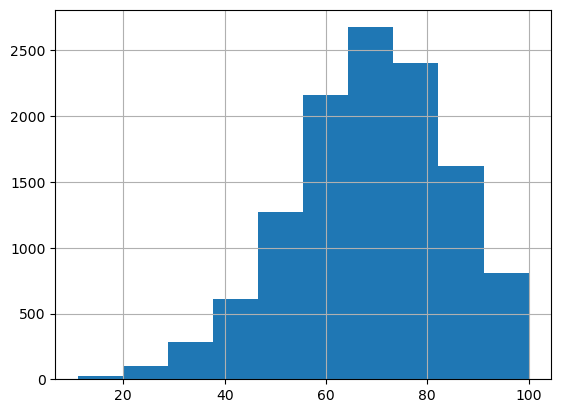

In [50]:
df_clas['Humidity9am'].hist()

# Regresión Lineal

In [15]:
from sklearn.linear_model import LinearRegression

In [18]:
reg = LinearRegression()

# reg.fit(x_train_reg, y_train_reg)

# Regresión logística

In [19]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logistica = LogisticRegression()

# logistica.fit(x_train_clas, y_train_clas)

# Redes neuronales

# Conclusiones finales